# Neural network examples
This jupyter notebook was used to run the neural network examples, and used to produce the plots. 


In [63]:
%matplotlib inline
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import pickle
import torch
import pickle
import stlcg

In [64]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [270]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

fontsize = 24

# Bump example

### generating bump data

In [66]:
np.random.seed(1)
x = np.arange(-2,2,0.1)
y = np.zeros(4*10)
y[:10] = -0.5
y[10:30] = 0.5
y[30:] = -0.5
y += np.random.randn(40)*0.1

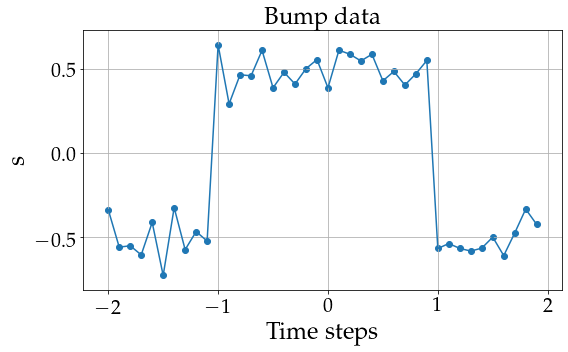

In [67]:
plt.figure(figsize=(8,5))
plt.plot(x,y)
plt.scatter(x,y)
plt.grid()
plt.xlabel("Time steps", fontsize=fontsize)
plt.ylabel("s", fontsize=fontsize)
plt.title("Bump data", fontsize=fontsize)
plt.tight_layout()

In [68]:
# save bump data
np.save("models/bump", np.stack([x,y]))

## creating a (very simple) neural network

In [69]:
class Bump(torch.nn.Module):

    def __init__(self, n, m, hidden_dim):
        super(Bump, self).__init__()
        self.network = torch.nn.Sequential(torch.nn.Linear(n, hidden_dim),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(hidden_dim, hidden_dim),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(hidden_dim, m))
    

    
    def forward(self, x):        
        return self.network(x)

In [70]:
#constructing neural network.
hidden_dim = 8

# n=1 (time), m=1 y value
# vanilla model to train with STL
torch.manual_seed(0)
bump = Bump(1, 1, hidden_dim)
optimizer = torch.optim.Adam(bump.parameters(), lr=0.01, weight_decay=0.10)

# model to train with STL
torch.manual_seed(0)
bump_stl = Bump(1, 1, hidden_dim)
optimizer_stl = torch.optim.Adam(bump_stl.parameters(), lr=0.01, weight_decay=0.10)

### creating input data

In [71]:
xx = torch.as_tensor(x).float().unsqueeze(-1)
yy = torch.as_tensor(y).float().unsqueeze(-1)
a = torch.as_tensor(0.48).float()
b = torch.as_tensor(0.52).float()

### creating stl formula

In [72]:
y_exp = stlcg.Expression('y_exp', yy)
ϕ1 = y_exp > a
ϕ2 = y_exp < b
ϕ = stlcg.Always(subformula=ϕ1 & ϕ2, interval=[10,29]) 
print(ϕ)

◻ [10, 29]( (y_exp >= input) ∧ (y_exp <= input) )


### training network without STL

0 loss = 11.056   mse = 11.056    robustness = -0.384
50 loss = 2.622   mse = 2.622    robustness = -0.439
100 loss = 2.206   mse = 2.206    robustness = -0.434
150 loss = 1.531   mse = 1.531    robustness = -0.396
200 loss = 1.148   mse = 1.148    robustness = -0.366
250 loss = 0.905   mse = 0.905    robustness = -0.329
300 loss = 0.841   mse = 0.841    robustness = -0.279
350 loss = 0.790   mse = 0.790    robustness = -0.261
400 loss = 0.761   mse = 0.761    robustness = -0.273
450 loss = 0.739   mse = 0.739    robustness = -0.233
500 loss = 0.742   mse = 0.742    robustness = -0.238
550 loss = 0.707   mse = 0.707    robustness = -0.223
600 loss = 0.692   mse = 0.692    robustness = -0.240
650 loss = 0.684   mse = 0.684    robustness = -0.245
700 loss = 0.678   mse = 0.678    robustness = -0.227
750 loss = 0.670   mse = 0.670    robustness = -0.226
800 loss = 0.665   mse = 0.665    robustness = -0.222
850 loss = 0.669   mse = 0.669    robustness = -0.211
900 loss = 0.659   mse = 0.65

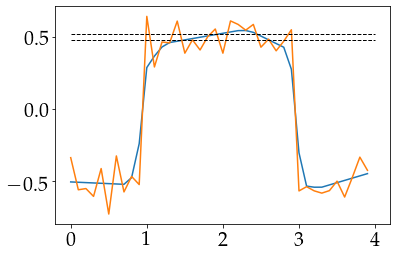

In [73]:
##### hyperparameters #####
γ = 0.0  # weighting on robustness loss
###########################

for _ in range(2000):
    optimizer.zero_grad()
    y_pred = bump(xx)
    ϕ_input = y_pred.unsqueeze(0) #.unsqueeze(-1)
    robustness = ϕ.robustness((ϕ_input, ϕ_input), scale=-1)
    mse = (y_pred - yy).pow(2).sum()
    loss = mse + γ*torch.relu(-robustness).squeeze()
    loss.backward()

    optimizer.step()
    if (_ % 50) == 0:
        print("%i loss = %.3f   mse = %.3f    robustness = %.3f"%(_, loss.detach().numpy(), mse.detach().numpy(), robustness.squeeze()))
plt.plot(x +2, bump(xx).squeeze().detach())
plt.plot(x + 2, yy.squeeze().detach())
plt.plot([0,4],[a.numpy()]*2, 'k--', linewidth=1)
plt.plot([0,4],[b.numpy()]*2, 'k--', linewidth=1)

In [74]:
γ = 0.0  # weighting on robustness loss
PATH = "models/bump_%.2f.model"%γ
np.save("models/bump_data_%.2f.npy"%γ, torch.cat([xx, bump(xx)], dim=-1).detach().numpy())
torch.save(bump.state_dict(), PATH)


### training network with STL

0 loss = 11.823   mse = 11.056    robustness = -0.384
50 loss = 3.456   mse = 2.694    robustness = -0.381
100 loss = 3.037   mse = 2.290    robustness = -0.373
150 loss = 2.427   mse = 1.740    robustness = -0.343
200 loss = 1.807   mse = 1.292    robustness = -0.258
250 loss = 1.374   mse = 1.044    robustness = -0.165
300 loss = 1.120   mse = 0.973    robustness = -0.073
350 loss = 0.837   mse = 0.742    robustness = -0.048
400 loss = 0.772   mse = 0.772    robustness = 0.000
450 loss = 0.705   mse = 0.642    robustness = -0.031
500 loss = 0.617   mse = 0.596    robustness = -0.011
550 loss = 0.667   mse = 0.607    robustness = -0.030
600 loss = 0.604   mse = 0.548    robustness = -0.028
650 loss = 0.547   mse = 0.547    robustness = 0.007
700 loss = 0.615   mse = 0.593    robustness = -0.011
750 loss = 0.540   mse = 0.526    robustness = -0.007
800 loss = 0.554   mse = 0.537    robustness = -0.009
850 loss = 0.538   mse = 0.532    robustness = -0.003
900 loss = 0.552   mse = 0.496 

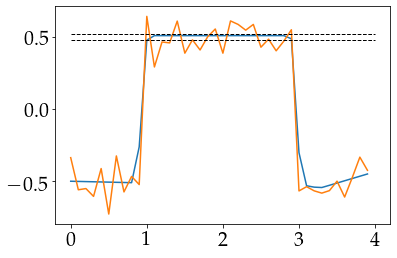

In [75]:
##### hyperparameters #####
γ = 2.  # weighting on robustness loss
###########################

for _ in range(2000):
    optimizer_stl.zero_grad()
    y_pred = bump_stl(xx)
    ϕ_input = y_pred.unsqueeze(0) #.unsqueeze(-1)
    robustness = ϕ.robustness((ϕ_input, ϕ_input), scale=-1)
    mse = (y_pred - yy).pow(2).sum()
    loss = mse + γ*torch.relu(-robustness).squeeze()
    loss.backward()

    optimizer_stl.step()
    if (_ % 50) == 0:
        print("%i loss = %.3f   mse = %.3f    robustness = %.3f"%(_, loss.detach().numpy(), mse.detach().numpy(), robustness.squeeze()))
plt.plot(x +2, bump_stl(xx).squeeze().detach())
plt.plot(x + 2, yy.squeeze().detach())
plt.plot([0,4],[a.numpy()]*2, 'k--', linewidth=1)
plt.plot([0,4],[b.numpy()]*2, 'k--', linewidth=1)

In [76]:
γ = 2.  # weighting on robustness loss
PATH = "models/bump_%.2f.model"%γ
np.save("models/bump_data_%.2f.npy"%γ, torch.cat([xx, bump_stl(xx)], dim=-1).detach().numpy())
torch.save(bump_stl.state_dict(), PATH)


### plotting results

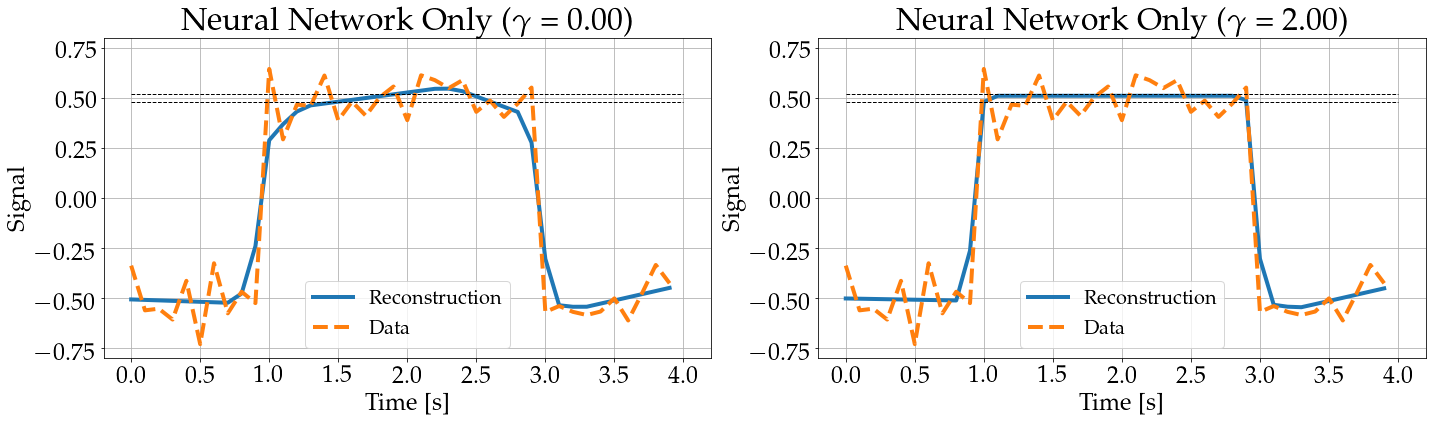

In [77]:
plt.figure(figsize=(20, 6))
a = 0.48
b = 0.52


bump_data = np.load("models/bump.npy")
x = bump_data[0,:] + 2
y = bump_data[1,:]

plt.subplot(1,2,1)
γ = 0.0  # weighting on robustness loss
data = np.load("models/bump_data_%.2f.npy"%γ).T
xx = data[0,:] + 2
yy = data[1,:]

plt.plot(xx, yy, linewidth=4, label="Reconstruction")
plt.plot(x, y, linewidth=4, label="Data", linestyle='--')
plt.plot([0,4],[a]*2, 'k--', linewidth=1)
plt.plot([0,4],[b]*2, 'k--', linewidth=1)
plt.ylim([-0.8, 0.8])
plt.xlabel("Time [s]", fontsize=fontsize)
plt.ylabel("Signal", fontsize=fontsize)
plt.legend(fontsize=fontsize-4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title("Neural Network Only ($\gamma$ = %.2f)"%γ, fontsize=fontsize+8)
plt.grid()
plt.tight_layout()


plt.subplot(1,2,2)
γ = 2.0  # weighting on robustness loss
data = np.load("models/bump_data_%.2f.npy"%γ).T
xx = data[0,:] + 2
yy = data[1,:]

plt.plot(xx, yy, linewidth=4, label="Reconstruction")
plt.plot(x, y, linewidth=4, label="Data", linestyle='--')
plt.plot([0,4],[a]*2, 'k--', linewidth=1)
plt.plot([0,4],[b]*2, 'k--', linewidth=1)
plt.ylim([-0.8, 0.8])
plt.xlabel("Time [s]", fontsize=fontsize)
plt.ylabel("Signal", fontsize=fontsize)
plt.legend(fontsize=fontsize-4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title("Neural Network Only ($\gamma$ = %.2f)"%γ, fontsize=fontsize+8)
plt.grid()
plt.tight_layout()

# Intent prediction example

### generating data

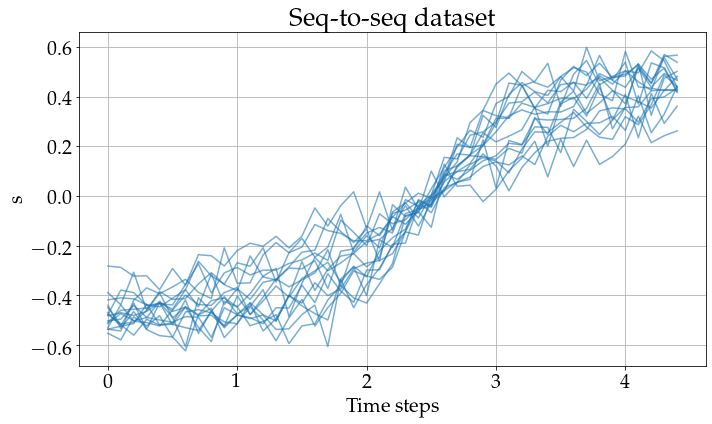

In [78]:
np.random.seed(1)
xx = np.arange(-2.5, 2, 0.1)
N = 256
x = np.stack([xx for i in range(N)])
y = 0.5*np.tanh(x * (0.3 + np.random.rand(N,1)*2)) + np.random.randn(*x.shape)*0.05
np.save("models/intent_train.npy", np.stack([x, y], axis=-1))


N = 16
x = np.stack([xx for i in range(N)])
y = 0.5*np.tanh(x * (0.3 + np.random.rand(N,1)*2)) + np.random.randn(*x.shape)*0.05
np.save("models/intent_test.npy", np.stack([x, y], axis=-1))


plt.figure(figsize=(10,6))
plt.plot(x.T + 2.5, y.T, alpha=0.6, c='#1f77b4')

plt.grid()
plt.xlabel("Time steps", fontsize=20)
plt.ylabel("s", fontsize=20)
plt.title("Seq-to-seq dataset", fontsize=26)
plt.tight_layout()
# plt.axis("equal")
plt.tight_layout()


## Visualizing data

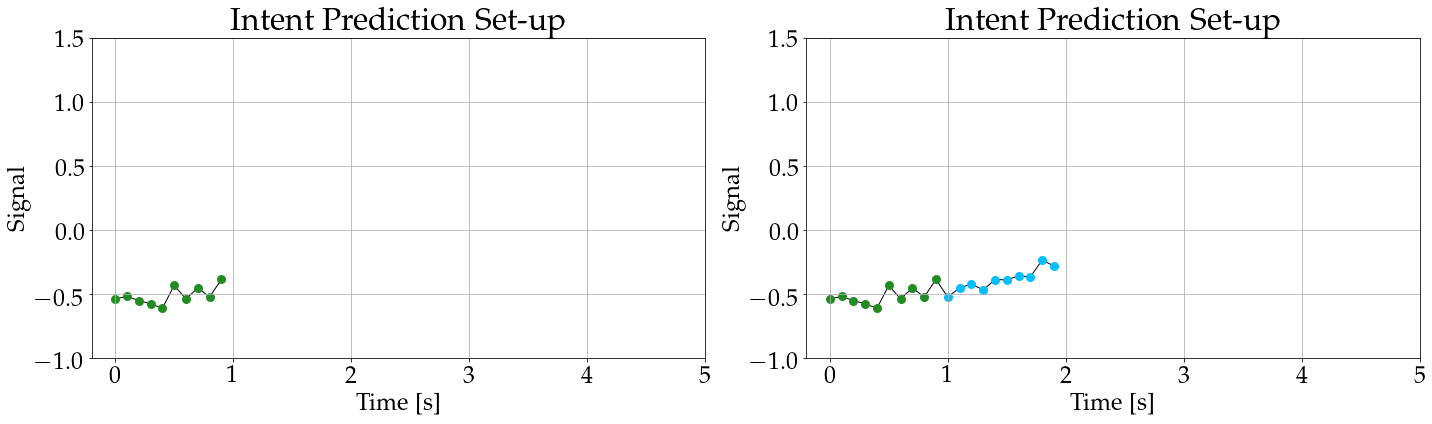

In [271]:
np.random.seed(1)
xx = np.arange(-2.5, 2, 0.1)
N = 1
x = np.stack([xx for i in range(N)])
y = 0.5*np.tanh(x * (0.3 + np.random.rand(N,1)*2)) + np.random.randn(*x.shape)*0.05
fontsize = 24


plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(xx[:10] + 2.5, y[:,:10].T, c='black', linewidth=1, zorder=-1)
plt.scatter(xx[:10] + 2.5, y[:,:10].T, c='forestgreen', linewidth=3)
plt.grid()
plt.title("Intent Prediction Set-up", fontsize=fontsize+8)
plt.xlim([-0.2, 5])
plt.ylim([-1, 1.5])
plt.xlabel("Time [s]", fontsize=fontsize)
plt.ylabel("Signal", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()


plt.subplot(1,2,2)
plt.plot(xx[:20] + 2.5, y[:,:20].T, c='black', linewidth=1, zorder=-1)
plt.scatter(xx[:10] + 2.5, y[:,:10].T, c='forestgreen', linewidth=3)
plt.scatter(xx[10:20] + 2.5, y[:,10:20].T, c='deepskyblue', linewidth=3)
plt.grid()
plt.title("Intent Prediction Set-up", fontsize=fontsize+8)
plt.xlim([-0.2, 5])
plt.ylim([-1, 1.5])
plt.xlabel("Time [s]", fontsize=fontsize)
plt.ylabel("Signal", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.tight_layout()

In [272]:
# setting up the model and dataset function for training
class PredictionDataset(Dataset):

    def __init__(self, fname, history_length=10, prediction_length=10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = np.load(fname)
        self.history_length = history_length
        self.prediction_length = prediction_length

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.data[idx, :self.history_length, :]
        y = self.data[idx, self.history_length:self.history_length+self.prediction_length, :]
        return {'x': x, 'y': y}
    
class Encoder(torch.nn.Module):

    def __init__(self, lstm_input_dim, lstm_dim):
        super(Encoder, self).__init__()
        self.network = torch.nn.LSTM(lstm_input_dim, lstm_dim, batch_first=True)
    
    def forward(self, x):
        return self.network(x)
    
class Decoder(torch.nn.Module):

    def __init__(self, lstm_input_dim, lstm_dim):
        super(Decoder, self).__init__()
        self.rnn_network = torch.nn.LSTM(lstm_input_dim, lstm_dim, batch_first=True)
        self.proj_network = torch.nn.Linear(lstm_dim, lstm_input_dim)
        self.h0 = torch.zeros([1,1,lstm_dim])
    
    def forward(self, x, rnn_state, ph):
        bs = x.shape[0]
        y_out = []
        for t in range(ph):
            output, rnn_state = self.rnn_network(x, rnn_state)
            x = self.proj_network(output)
            y_out.append(x)
        return torch.cat(y_out, dim=1)
    
class Predict(torch.nn.Module):

    def __init__(self, lstm_input_dim, lstm_dim):
        super(Predict, self).__init__()
        
        self.enc = Encoder(lstm_input_dim, lstm_dim)
        self.dec = Decoder(lstm_input_dim, lstm_dim)
        
    def forward(self, x, ph):
        enc_out, rnn_state = self.enc(x)
        return self.dec(self.dec.proj_network(enc_out[:,-1:,:]), rnn_state, ph)




In [244]:
#creating the model and training data

hidden_dim = 4

# n=1 (time), m=1 y value
# vanilla model to train without STL
torch.manual_seed(0)
pred = Predict(1, hidden_dim)
optimizer = torch.optim.Adam(pred.parameters(), lr=0.01, weight_decay=0)

# model to train with STL
torch.manual_seed(0)
pred_stl = Predict(1, hidden_dim)
optimizer_stl = torch.optim.Adam(pred_stl.parameters())


dataset = PredictionDataset("models/intent_train.npy")

train_loader = DataLoader(dataset, batch_size=8, shuffle=True)


### setting up STL formula

In [239]:
yf = stlcg.Expression('yf', yy)
ϕ2 = yf > torch.as_tensor(0.4).float()
ϕ3 = yf < torch.as_tensor(0.6).float()
ϕ = ϕ2 & ϕ3
ψ = stlcg.Always(subformula=ϕ, interval=[0,5])   # feeding trajectory not in reversed, so this time interval is actually the end of the trajectory

### training the network without STL

In [245]:
γ = 0.0     # weighting on robustness loss

In [246]:
for _ in range(50):
    for batch_idx, data_dict in enumerate(train_loader):
        x = data_dict['x'].float()[:,:,1:]
        y = data_dict['y'].float()[:,:,1:]
        optimizer.zero_grad()
        y_pred = pred(x, 35)
        y_loss = y_pred[:,:10,:]

        y_future = y_pred[:,-35:,:]

        robustness = torch.relu(-ψ.robustness((y_future, y_future), scale=-1)).sum()
        mse = (y_loss - y).pow(2).sum(-1).mean(1).mean()
        loss = mse + γ*robustness
        loss.backward()

        optimizer.step()
    print("%i loss = %.3f   mse = %.3f    robustness = %.3f"%(_, loss.detach().numpy(), mse.detach().numpy(), robustness.squeeze()))

0 loss = 0.012   mse = 0.012    robustness = 5.900
1 loss = 0.008   mse = 0.008    robustness = 6.089
2 loss = 0.010   mse = 0.010    robustness = 5.869
3 loss = 0.019   mse = 0.019    robustness = 5.762
4 loss = 0.014   mse = 0.014    robustness = 5.668
5 loss = 0.008   mse = 0.008    robustness = 5.163
6 loss = 0.004   mse = 0.004    robustness = 4.387
7 loss = 0.005   mse = 0.005    robustness = 4.285
8 loss = 0.006   mse = 0.006    robustness = 4.250
9 loss = 0.007   mse = 0.007    robustness = 4.284
10 loss = 0.004   mse = 0.004    robustness = 4.216
11 loss = 0.004   mse = 0.004    robustness = 4.176
12 loss = 0.005   mse = 0.005    robustness = 4.195
13 loss = 0.005   mse = 0.005    robustness = 4.262
14 loss = 0.005   mse = 0.005    robustness = 4.217
15 loss = 0.005   mse = 0.005    robustness = 4.237
16 loss = 0.004   mse = 0.004    robustness = 4.236
17 loss = 0.004   mse = 0.004    robustness = 4.189
18 loss = 0.003   mse = 0.003    robustness = 4.115
19 loss = 0.004   mse 

In [254]:
PATH = "models/intent_%.2f.model"%γ
torch.save(pred.state_dict(), PATH)

### training the network with STL

In [258]:
γ = 0.1     # weighting on robustness loss

In [259]:
for _ in range(50):
    for batch_idx, data_dict in enumerate(train_loader):
        x = data_dict['x'].float()[:,:,1:]
        y = data_dict['y'].float()[:,:,1:]
        optimizer_stl.zero_grad()
        y_pred = pred_stl(x, 35)
        y_loss = y_pred[:,:10,:]

        y_future = y_pred[:,-35:,:]

        robustness = torch.relu(-ψ.robustness((y_future, y_future), scale=-1)).sum()
        mse = (y_loss - y).pow(2).sum(-1).mean(1).mean()
        loss = mse + γ*robustness
        loss.backward()

        optimizer_stl.step()
    print("%i loss = %.3f   mse = %.3f    robustness = %.3f"%(_, loss.detach().numpy(), mse.detach().numpy(), robustness.squeeze()))

0 loss = 0.480   mse = 0.143    robustness = 3.362
1 loss = 0.460   mse = 0.184    robustness = 2.765
2 loss = 0.386   mse = 0.185    robustness = 2.007
3 loss = 0.154   mse = 0.154    robustness = 0.000
4 loss = 0.012   mse = 0.012    robustness = 0.000
5 loss = 0.023   mse = 0.023    robustness = 0.000
6 loss = 0.012   mse = 0.012    robustness = 0.000
7 loss = 0.012   mse = 0.012    robustness = 0.000
8 loss = 0.022   mse = 0.022    robustness = 0.000
9 loss = 0.012   mse = 0.012    robustness = 0.000
10 loss = 0.012   mse = 0.012    robustness = 0.000
11 loss = 0.014   mse = 0.014    robustness = 0.000
12 loss = 0.009   mse = 0.009    robustness = 0.000
13 loss = 0.009   mse = 0.009    robustness = 0.000
14 loss = 0.006   mse = 0.006    robustness = 0.000
15 loss = 0.007   mse = 0.007    robustness = 0.000
16 loss = 0.008   mse = 0.008    robustness = 0.000
17 loss = 0.014   mse = 0.014    robustness = 0.000
18 loss = 0.013   mse = 0.013    robustness = 0.000
19 loss = 0.011   mse 

In [261]:
PATH = "models/intent_%.2f.model"%γ
torch.save(pred_stl.state_dict(), PATH)

### preparing test set data

In [273]:
dataset = PredictionDataset("models/intent_test.npy")
test_loader = DataLoader(dataset, batch_size=16, shuffle=False)
for batch_idx, data_dict in enumerate(test_loader):
    x = data_dict['x'].float()[:,:,1:]
    y = data_dict['y'].float()[:,:,1:]
    break
    
xx = np.arange(-2.5, 2, 0.1)


## Plotting comparison plots

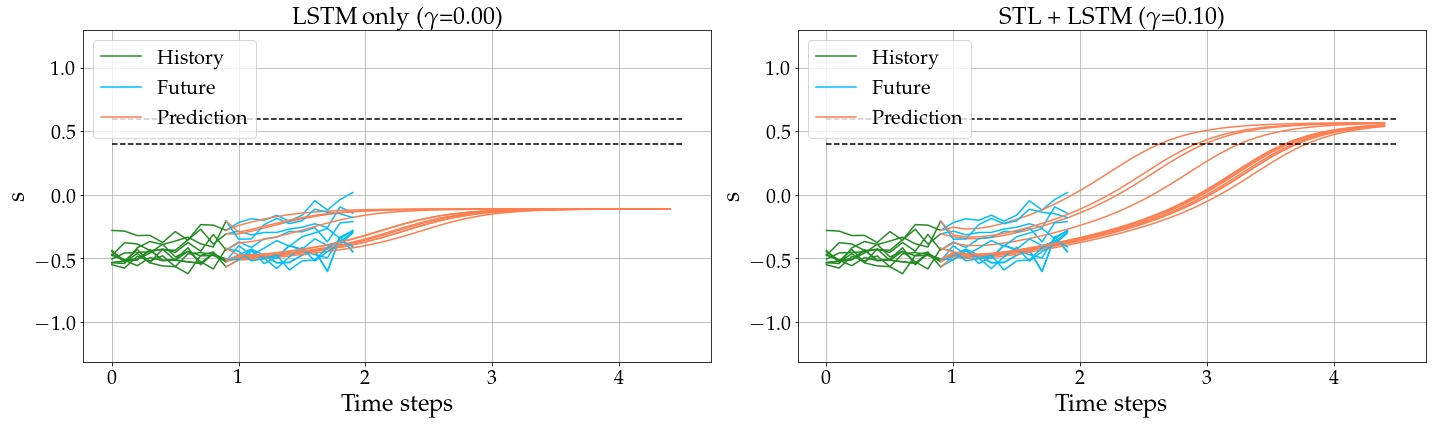

In [274]:
model = Predict(1, 4)

plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
γ = 0.0
PATH = "models/intent_%.2f.model"%γ
model.load_state_dict(torch.load(PATH))
model.eval()
y_pred = model(x, 35)

for idx in range(0,1):
    x_history = xx[:10]
    history = x.numpy()[idx,:,:]
    plt.plot(x_history+2.5, history, c="forestgreen", label="History")
    
    x_future = xx[9:20]
    future = y.numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="deepskyblue", label="Future")
    
    x_future = xx[9:]
    future = y_pred.detach().numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="coral", label="Prediction")
    
    

for idx in range(0,10):
    x_history = xx[:10]
    history = x.numpy()[idx,:,:]
    plt.plot(x_history+2.5, history, c="forestgreen")
    
    x_future = xx[9:20]
    future = y.numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="deepskyblue")
    
    x_future = xx[9:]
    future = y_pred.detach().numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="coral")

plt.plot([0,4.5],[0.4, 0.4], 'k--')
plt.plot([0,4.5],[0.6, 0.6], 'k--')
plt.xlim([-2.5, 2])
plt.xlim([-1, 1])
plt.axis("equal")
plt.legend(loc="upper left", fontsize=fontsize-4)
plt.title("LSTM only ($\gamma$=%.2f)"%γ, fontsize=fontsize)
plt.xlabel("Time steps", fontsize=fontsize)
plt.ylabel("s", fontsize=fontsize)
plt.tight_layout()
plt.grid()



plt.subplot(1,2,2)
γ = 0.1
PATH = "models/intent_%.2f.model"%γ
model.load_state_dict(torch.load(PATH))
model.eval()
y_pred = model(x, 35)

for idx in range(0,1):
    x_history = xx[:10]
    history = x.numpy()[idx,:,:]
    plt.plot(x_history+2.5, history, c="forestgreen", label="History")
    
    x_future = xx[9:20]
    future = y.numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="deepskyblue", label="Future")
    
    x_future = xx[9:]
    future = y_pred.detach().numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="coral", label="Prediction")
    
    

for idx in range(0,10):
    x_history = xx[:10]
    history = x.numpy()[idx,:,:]
    plt.plot(x_history+2.5, history, c="forestgreen")
    
    x_future = xx[9:20]
    future = y.numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="deepskyblue")
    
    x_future = xx[9:]
    future = y_pred.detach().numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="coral")

plt.plot([0,4.5],[0.4, 0.4], 'k--')
plt.plot([0,4.5],[0.6, 0.6], 'k--')
plt.xlim([-2.5, 2])
plt.xlim([-1, 1])
plt.axis("equal")
plt.legend(loc="upper left", fontsize=fontsize-4)
plt.title("STL + LSTM ($\gamma$=%.2f)"%γ, fontsize=fontsize)
plt.xlabel("Time steps", fontsize=fontsize)
plt.ylabel("s", fontsize=fontsize)
plt.tight_layout()
plt.grid()

